# 1. Introducción

Una contingencia ambiental se presenta cuando un contaminante de la atmósfera rebasa los límites establecidos por las normas de calidad del aire vigentes. En diversos países existen contingencias ambientales, el área metropolitana de la ciudad de Monterrey en México es muy frecuente.

Las condiciones del clima como presión, temperatura, humedad relativa, luz solar, velocidad y dirección del viento, etc. afectan la concentración de contaminantes.



Existe la propuesta de implementar un programa de verificación vehicular. Se pretende investigar si la contaminación está ligada al tráfico usando la hora del día cómo representante del mismo.



A continuación trataremos de predecir la concentración de los contaminantes  
$O3$ y $PM2.5$ usando el modelo de regresión lineal múltiple.


El modelo de regresión lineal permite predecir el valor de una variable y en términos de otras variables
$x_1,x_2,\ldots,x_n.$ a través de:
$y=b_0+b_1x_1+b_2x_2+\cdots+b_nx_n + \varepsilon$

Para elegir las variables independientes nos basaremos en la matriz de correlación.

## Instalar pyspark

In [ ]:
#!pip install pyspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

## Iniciar una sesión con pyspark

In [ ]:
import findspark
import numpy as np
findspark.init()
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.types import StringType, BooleanType, IntegerType

In [ ]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

## Paso 1. Cargar los datos

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
path_datos="/content/drive/MyDrive/datos_reto.csv"
df = spark.read.csv(path_datos,header=True, inferSchema=True).coalesce(2)
df.show(10)

+---------+-----+---+-------+-------+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
|     Date|Month|Day|DayWeek|WeekDay|Hour|  CO|  NO| NO2| NOX| O3|PM10|PM2.5|  PRS|RAINF| RH|   SR|TOUT|WSR|WDV|
+---------+-----+---+-------+-------+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
|01-ene-15|    1|  1|    jue|      5|   1|2.51|10.2|12.9|23.1| 10| 139|   80|725.4| 0.01| 96|  0.0|3.91|7.2|344|
|01-ene-15|    1|  1|    jue|      5|   2|2.41| 9.2|11.6|20.8|  7|  42|   29|725.0| 0.02| 96|  0.0|3.81|6.3|341|
|01-ene-15|    1|  1|    jue|      5|   3|2.39| 8.1|11.8|19.9|  7|  23|    9|724.4|  0.0| 96|  0.0|3.85|5.2|346|
|01-ene-15|    1|  1|    jue|      5|   5|2.26| 5.3| 8.9|14.2|  7|  23|   14|724.0| 0.01| 96|  0.0|3.79|5.6|336|
|01-ene-15|    1|  1|    jue|      5|   8|2.25| 7.2|10.2|17.4|  5|  15|    8|724.3|  0.0| 96|0.023|3.93|4.8|354|
|01-ene-15|    1|  1|    jue|      5|   9|2.21| 5.8| 8.2|14.0|  7|  16|    6|724.3|  0.0| 96|0.0

# Paso 2. Analizar características del conjunto de datos.

In [ ]:
#Número de renglones
print('El conjunto de datos tiene  ', df.count(),' renglones.\n')
print('El conjunto de datos tiene  ', len(df.columns), ' columnsas.\n')
print('Estos son los nombres de las columnas:\n ', df.columns,'\n')
print('Estas son los tipos de variable de cada columna: ', df.printSchema())

El conjunto de datos tiene   3859  renglones.

El conjunto de datos tiene   20  columnsas.

Estos son los nombres de las columnas:
  ['Date', 'Month', 'Day', 'DayWeek', 'WeekDay', 'Hour', 'CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5', 'PRS', 'RAINF', 'RH', 'SR', 'TOUT', 'WSR', 'WDV'] 

root
 |-- Date: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- DayWeek: string (nullable = true)
 |-- WeekDay: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- CO: double (nullable = true)
 |-- NO: double (nullable = true)
 |-- NO2: double (nullable = true)
 |-- NOX: double (nullable = true)
 |-- O3: integer (nullable = true)
 |-- PM10: integer (nullable = true)
 |-- PM2.5: integer (nullable = true)
 |-- PRS: double (nullable = true)
 |-- RAINF: double (nullable = true)
 |-- RH: integer (nullable = true)
 |-- SR: double (nullable = true)
 |-- TOUT: double (nullable = true)
 |-- WSR: double (nullable = true)
 |-- WDV: integer (n

## Paso 2. Eliminar y renombrar variables

In [ ]:
df = df.withColumnRenamed('PM2.5','PM25')
df = df.drop('Date','Month','Day','DayWeek','WeekDay','CO','NO','NO2','NOX','PM10')
df = df.dropDuplicates()
df = df.na.drop()
df.columns

['Hour', 'O3', 'PM25', 'PRS', 'RAINF', 'RH', 'SR', 'TOUT', 'WSR', 'WDV']

## Estadística descriptiva de las variables.

In [ ]:
df.describe().show()

+-------+------------------+------------------+------------------+------------------+--------------------+-----------------+-------------------+------------------+------------------+------------------+
|summary|              Hour|                O3|              PM25|               PRS|               RAINF|               RH|                 SR|              TOUT|               WSR|               WDV|
+-------+------------------+------------------+------------------+------------------+--------------------+-----------------+-------------------+------------------+------------------+------------------+
|  count|              3859|              3859|              3859|              3859|                3859|             3859|               3859|              3859|              3859|              3859|
|   mean|12.037833635656906|22.658719875615443|27.675822752008294| 719.6299559471377|0.002650945840632281|71.04845814977973|0.18258227523114745|22.018968644726662|7.3314589271832045|127.522155

## Cálculo de correlaciones

### Importar paquetes.

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [ ]:
df_columns = df.columns

### Ensamblar el vector de columnas

In [ ]:
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_columns, outputCol = vector_col)
df_vector = assembler.transform(df).select(vector_col)

### Se obtiene la correlación entre las variables

In [ ]:
rl = Correlation.corr(df_vector,vector_col)
pearson_corr_arr = np.matrix( rl.collect()[0]["pearson({})".format(vector_col)].values).reshape(len(df_columns),len(df_columns))
pearson_corr_df = pd.DataFrame(data=pearson_corr_arr,index=df_columns,columns=df_columns)

In [ ]:
pearson_corr_df

,Hour,O3,PM25,PRS,RAINF,RH,SR,TOUT,WSR,WDV
Hour,1.000000,0.228381,0.097884,-0.047857,0.020795,-0.362518,0.048570,0.218742,0.424072,-0.128215
O3,0.228381,1.000000,-0.008811,-0.219732,-0.030142,-0.655588,0.691927,0.527154,0.466254,-0.198798
PM25,0.097884,-0.008811,1.000000,-0.178029,0.030746,0.036154,-0.037306,0.083703,-0.071178,-0.032373
PRS,-0.047857,-0.219732,-0.178029,1.000000,0.005096,0.128509,-0.140521,-0.661163,-0.216032,0.134273
RAINF,0.020795,-0.030142,0.030746,0.005096,1.000000,0.065507,-0.035976,-0.029789,-0.015195,0.003243
RH,-0.362518,-0.655588,0.036154,0.128509,0.065507,1.000000,-0.459958,-0.550910,-0.414917,0.068477
SR,0.048570,0.691927,-0.037306,-0.140521,-0.035976,-0.459958,1.000000,0.456226,0.202181,-0.101123
TOUT,0.218742,0.527154,0.083703,-0.661163,-0.029789,-0.550910,0.456226,1.000000,0.465796,-0.264962
WSR,0.424072,0.466254,-0.071178,-0.216032,-0.015195,-0.414917,0.202181,0.465796,1.000000,-0.149348
WDV,-0.128215,-0.198798,-0.032373,0.134273,0.003243,0.068477,-0.101123,-0.264962,-0.149348,1.000000


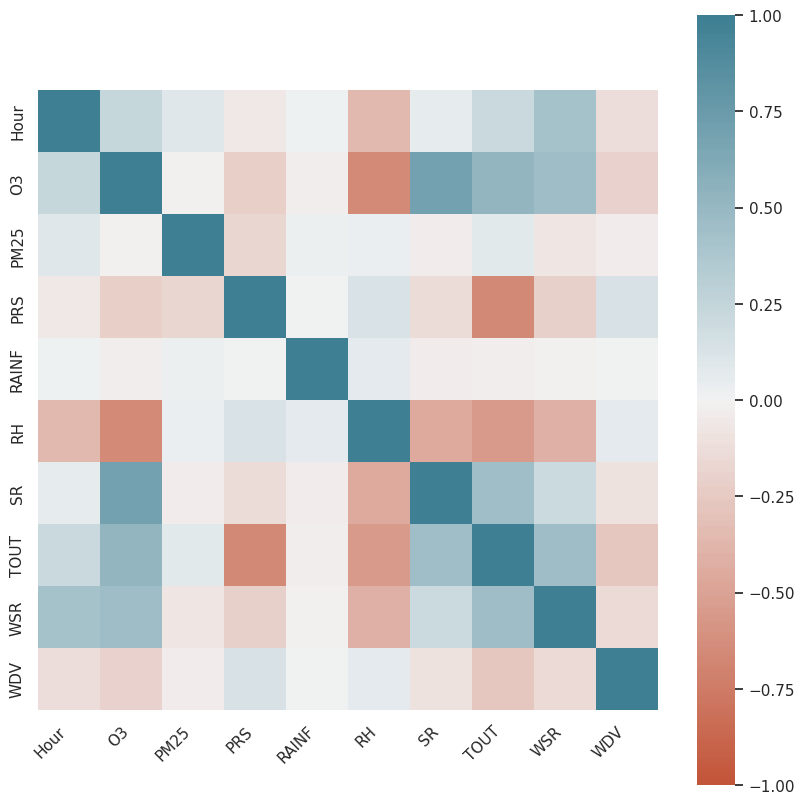

In [ ]:
import seaborn as sns
sns.set(color_codes= True, font_scale=1.0)
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))

ax = sns.heatmap(
    pearson_corr_df,
    vmin=-1, vmax=1, center = 0,
    cmap =sns.diverging_palette(20,220, n=200),
    square = True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation =45,
    horizontalalignment = 'right'
);


Obsevamos que O3 tienen mayor correlación con las siguietes variables ambientales:


*   SR
*   TOUT
*   WSR

Todas las variables independientes tienen correlación débil con 'PM25'. Las variables con mayor correlación son


*   PSR
*   HOUR








## Diagramas de Dispersión

### Verificamos que las variables que se graficarán con O3  tengan la misma cantidad de valores

In [ ]:
df_O3 = df.select('O3')
df_SR = df.select('SR')
df_TOUT = df.select('TOUT')
df_WSR = df.select('WSR')

In [ ]:
print( df_O3.count())
print(df_SR.count())
print(df_TOUT.count())
print(df_WSR.count())

3859
3859
3859
3859


### Verificamos que las variables que se graficarán con PM25 tengan la misma cantidad de valores.

In [ ]:
df_PM25=df.select('PM25')
df_Hour = df.select('Hour')
df_PRS = df.select('PRS')

In [ ]:
print(df_PM25.count())
print(df_Hour.count())
print(df_PRS.count())

3859
3859
3859


### Creamos los arreglos


In [ ]:
# Variables con alta correlación con O3
df_O3 = df_O3.rdd.map(lambda row: row.O3)
df_SR = df_SR.rdd.map(lambda row: row.SR)
df_TOUT = df_TOUT.rdd.map(lambda row: row.TOUT)
df_WSR = df_WSR.rdd.map(lambda row: row.WSR)


df_PM25=df_PM25.rdd.map(lambda row : row.PM25)
df_Hour = df_Hour.rdd.map(lambda row: row.Hour)
df_PRS = df.rdd.map(lambda row: row.PRS)


In [ ]:
# Variables con alta correlación con O3
arr_df_O3 = df_O3.collect()
arr_df_SR = df_SR.collect()
arr_df_TOUT = df_TOUT.collect()
arr_df_WSR = df_WSR.collect()


arr_df_PM25=df_PM25.collect()
arr_df_Hour = df_Hour.collect()
arr_df_PRS = df_PRS.collect()

### Graficamos


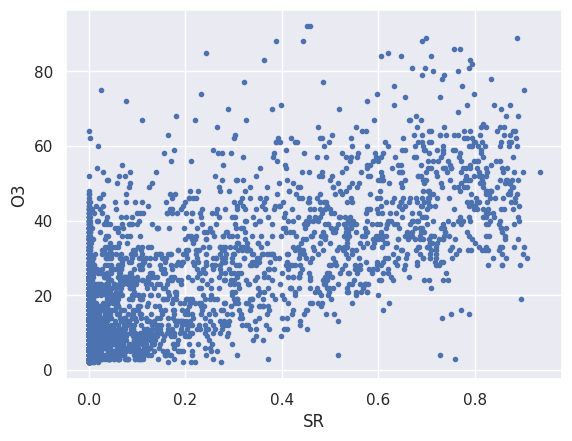

In [ ]:
plt.plot(arr_df_SR,arr_df_O3, 'b.')
plt.ylabel("O3")
plt.xlabel("SR")
plt.show()

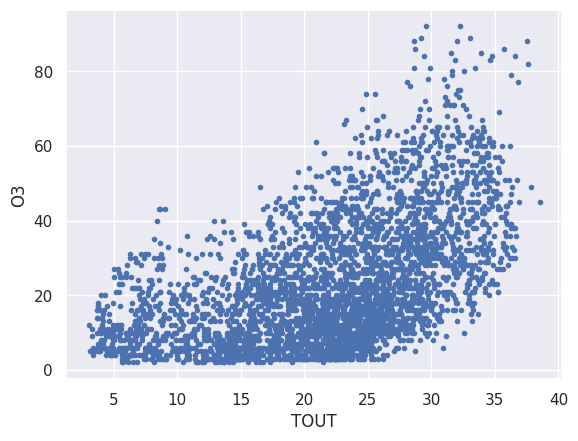

In [ ]:
plt.plot(arr_df_TOUT,arr_df_O3, 'b.')
plt.ylabel("O3")
plt.xlabel("TOUT")
plt.show()

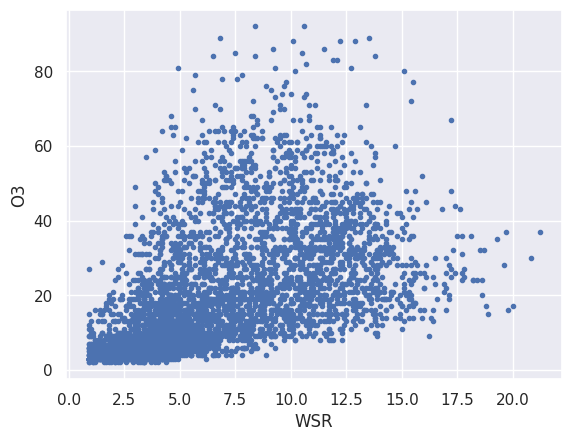

In [ ]:
plt.plot(arr_df_WSR,arr_df_O3, 'b.')
plt.ylabel("O3")
plt.xlabel("WSR")
plt.show()

Las gráficas muestran una correlación positivoa entre el Ozono y cada una del las siguientes variables:


*   La radiación solar (SR).
*   La temperatura (TOUT).
*   La velocidad del viento (WSR).

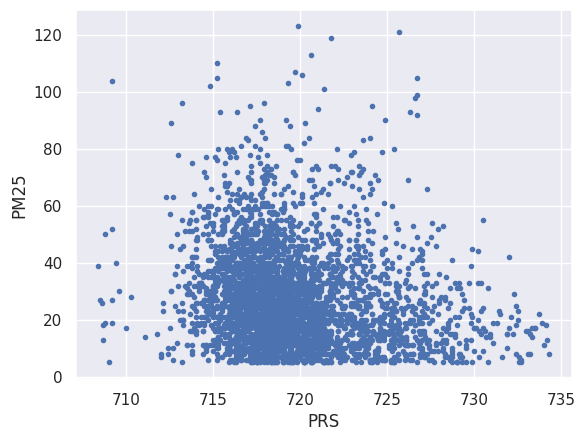

In [ ]:
plt.plot(arr_df_PRS,arr_df_PM25, 'b.')
plt.ylabel("PM25")
plt.xlabel("PRS")
plt.show()

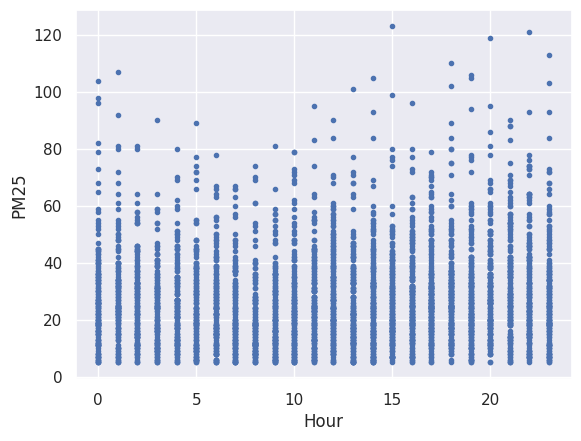

In [ ]:
plt.plot(arr_df_Hour,arr_df_PM25, 'b.')
plt.ylabel("PM25")
plt.xlabel("Hour")
plt.show()

Se corrobora una correlación débil entre las Particular menores a 2.5 microns y las variables hora y radiación solar.

## Modelo de regresión lineal múltiple para el O3


### Ajuste de los datos al modelo

In [ ]:
# pasamos los datos de dataset a un vectores
atributos1=['SR','TOUT','WSR']
assembler = VectorAssembler(inputCols=atributos1, outputCol = 'atributosm1')
output = assembler.transform(df)
wk_df = output.select('atributosm1','O3')
wk_df.show(10)

+-----------------+---+
|      atributosm1| O3|
+-----------------+---+
|  [0.0,18.14,4.8]| 15|
|   [0.0,21.5,7.1]| 16|
| [0.01,15.54,5.4]|  9|
|[0.018,14.19,2.9]|  3|
|  [0.0,22.74,3.6]|  3|
|[0.307,23.92,5.4]| 19|
| [0.0,27.72,11.6]| 27|
| [0.01,22.53,1.9]|  3|
|[0.017,23.17,2.1]|  7|
|[0.008,22.33,4.4]|  3|
+-----------------+---+
only showing top 10 rows



In [ ]:
from pyspark.ml.regression import LinearRegression
regressor1 = LinearRegression(featuresCol = 'atributosm1', labelCol = 'O3')
train_data1 , test_data1= wk_df.randomSplit([0.8,0.2])
regressor1 = regressor1.fit(train_data1)

In [ ]:
print ("The coefficient of the model is : %a",'\n', regressor1.coefficients,'\n')
print ("The Intercept of the model is : %f", '\n',regressor1.intercept,'\n')

The coefficient of the model is : %a 
 [36.220646833266585,0.28226386589595254,1.245413293422247] 

The Intercept of the model is : %f 
 0.6746924527587235 



### Predicción

In [ ]:
#To predict the prices on testing set
Pred_lr1 = regressor1.evaluate(test_data1)
#Predict the model
Pred_lr1.predictions.show(10)

+--------------+---+------------------+
|   atributosm1| O3|        prediction|
+--------------+---+------------------+
|[0.0,3.29,7.9]| 11| 11.44210558959216|
|[0.0,3.75,4.7]|  5| 7.586624428953106|
|[0.0,3.78,6.4]| 14| 9.712294943747805|
|[0.0,3.85,5.2]|  7| 8.237557462253825|
|[0.0,3.86,4.2]|  5| 6.994966807490538|
|[0.0,4.07,4.1]| 12| 6.929700889986463|
|[0.0,4.16,4.7]| 15| 7.702352613970447|
|[0.0,4.25,8.6]| 11|12.584868206247846|
|[0.0,4.32,5.6]| 10| 8.868386796593821|
|[0.0,4.47,3.5]|  5| 6.295358460291496|
+--------------+---+------------------+
only showing top 10 rows



### Evaluación del modelo

In [ ]:
Summary = regressor1.summary
print(Summary.r2)

0.6015420824132363


## Modelo de regresión lineal múltiple para PM25

### Ajuste de los datos al modelo de regresión

In [ ]:
# pasamos los datos de dataset a un vectores
atributos2=['Hour','PRS']
assembler2 = VectorAssembler(inputCols=atributos2, outputCol = 'atributosm2')
output2 = assembler2.transform(df)
wk_df2 = output2.select('atributosm2','PM25')
wk_df2.show(10)

+------------+----+
| atributosm2|PM25|
+------------+----+
|[21.0,718.0]|  23|
|[19.0,723.4]|  24|
| [7.0,726.5]|   8|
| [7.0,720.9]|  48|
|[22.0,716.7]|  50|
|[10.0,718.7]|   7|
|[19.0,718.8]|  41|
|[22.0,717.1]|  78|
| [2.0,716.2]|  23|
| [5.0,714.0]|  45|
+------------+----+
only showing top 10 rows



In [ ]:

regressor2 = LinearRegression(featuresCol = 'atributosm2', labelCol = 'PM25')
train_data2 , test_data2= wk_df2.randomSplit([0.8,0.2])
regressor2 = regressor2.fit(train_data2)

In [ ]:
print ("The coefficient of the model is : %a",'\n', regressor2.coefficients,'\n')
print ("The Intercept of the model is : %f", '\n',regressor2.intercept,'\n')

The coefficient of the model is : %a 
 [0.2150905440253319,-0.8166553608455189] 

The Intercept of the model is : %f 
 612.8107921677888 



### Predicciones

In [ ]:
#To predict the prices on testing set
Pred_lr2 = regressor2.evaluate(test_data2)
#Predict the model
Pred_lr2.predictions.show(10)

+-----------+----+------------------+
|atributosm2|PM25|        prediction|
+-----------+----+------------------+
|[0.0,713.8]|  40|29.882195596257475|
|[0.0,715.7]|  14|28.330550410650858|
|[0.0,716.4]|  19|27.758891658059042|
|[0.0,716.9]|  36|27.350563977636284|
|[0.0,717.3]|  35| 27.02390183329817|
|[0.0,717.6]|  38|26.778905225044355|
|[0.0,718.2]|  36|26.288912008537068|
|[0.0,718.3]|   7| 26.20724647245254|
|[0.0,718.9]|  33|25.717253255945252|
|[0.0,719.4]|  41|25.308925575522494|
+-----------+----+------------------+
only showing top 10 rows



### Evaluación del modelo

In [ ]:
Summary2 = regressor2.summary
print(Summary2.r2)

0.04091449575382544


# Conclusiones


El modelo obtenido para predecir el ozono es

O3= 36.22 SR + 0.28 TOUT+1.24 WSR + 0.67

El coeficiente de determinación en ese caso es del 0.60, por lo que el modelo
alcanza a explicar la relación entre las variables independientes y la dependiente de manera aceptable.

Entonces el modelo nos indica que

*   Por cada unidad que aumenta la radiación solar, el ozono aumenta 36.22 unidades.
*   Por cada unidad que aumenta la tempreatura, el ozono aumenta 028
*   Por cada unidad que aumenta la velocidad del viento el ozono aumenta 1.24 unidades.
*   Cuando el valor de las tres  variables independientes es cero, el valor esperado de ozono es 0.67.







El modelo obtenido para predecir el PM25 es:


PM25 = 0.21Hour +-0.81 PRS+ 612.81

El coeficiente de determinación es de 0.04, por lo que el modelo no alcanza a explicar los niveles del ozono.

Tomando en cuenta los modelos obtenidos y el análisis de correlación realizado. La Hora no es un factor que influya en la concentración de los contaminantes O3 y PM25. Ya que el trafico vehicular está representado por la hora, el presente estudio no justifica la implantación de un esquema de verificación vehicular.
No obstante, sería relevante evaluar otros modelos y tratar de predecir otros contaminantes antes de tomar una decisión final.